In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import cross_entropy
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset, random_split

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

import tarfile
import os

In [2]:
download_url("http://files.fast.ai/data/cifar10.tgz", root='.')

In [3]:
filename="./cifar10.tgz"
with tarfile.open(filename, 'r:gz') as tarfile:
    tarfile.extractall(path='.')

In [4]:
os.listdir('.')

['cifar10', 'cifar10.tgz', '__notebook_source__.ipynb']

In [5]:
train_path ="./cifar10/train"
test_path="./cifar10/test"
dataset = ImageFolder(train_path, transform=ToTensor())
testset = ImageFolder(test_path, transform=ToTensor())

In [6]:
dataset[0][0].shape

torch.Size([3, 32, 32])

In [7]:
target_classes = dataset.classes
dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
def show_img(img, label):
    print("True Label :", label, '(',target_classes[label],')')
    plt.imshow(img.permute(1,2,0))
    plt.show()

True Label : 0 ( airplane )


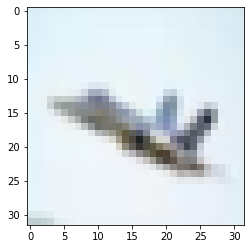

In [9]:
img, label = dataset[0]
show_img(img, label)

True Label : 4 ( deer )


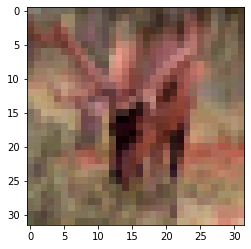

In [10]:
img, label = dataset[20000]
show_img(img, label)

In [11]:
len(dataset)

50000

In [12]:
batch_size = 128

In [13]:
train_data, val_data = random_split(dataset, [40000, 10000])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_data, batch_size=batch_size*2)
test_loader = DataLoader(testset, batch_size=batch_size*2)

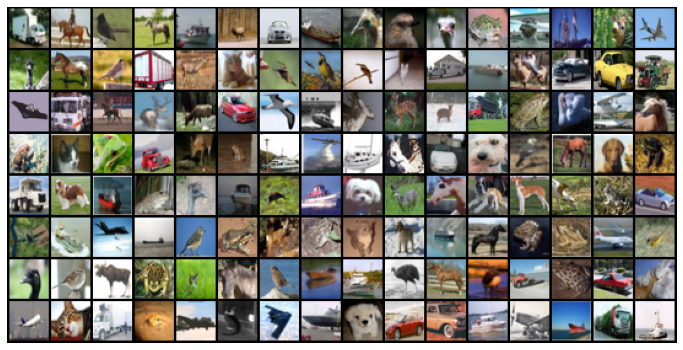

In [14]:
for imgs, labs in train_loader:
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(make_grid(imgs, nrow=16).permute((1,2,0)))
    break

In [15]:
def accuracy(preds, targets):
    maxval, label = torch.max(preds, dim=1)
    return torch.tensor(torch.sum(label == targets).item()/len(label))

In [16]:
def accuracy(preds, targets):
    maxval, label = torch.max(preds, dim=1)
    return torch.tensor(torch.sum(label == targets).item()/len(label))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        outputs = self(images)
        loss = cross_entropy(outputs, targets)
        return loss
    
    def validation_step(self, batch):
        images, targets = batch
        outputs = self(images)
        loss = cross_entropy(outputs, targets)
        acc = accuracy(outputs, targets)
        return {'loss':loss.detach(),'acc':acc.detach()}
    
    def validation_epoch_end(self, result):
        v_loss = [x['loss'] for x in result]
        val_loss = torch.stack(v_loss).mean()
        
        v_acc = [x['acc'] for x in result]
        val_acc = torch.stack(v_acc).mean()
        return {'loss': val_loss.item(), 'acc':val_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("epoch {} => val_loss {}, val_acc: {}".format(epoch, result['loss'], result['acc']))

def CfarCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernal_size=3, stride=1, padding=1).
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernal_size=3, stride=1, padding=1).
            nn.ReLU(),
            nn.MaxPool2d(2,2), 
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernal_size=3, stride=1, padding=1).
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output: 256 x 4 x 4
            
            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

model = CfarCnnModel()

TypeError: CfarCnnModel() missing 1 required positional argument: 'ImageClassificationBase'

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [18]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(model, device);

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
model = to_device(Cifar10CnnModel(), device)

In [30]:
evaluate(model, val_loader)

{'val_loss': 2.3031089305877686, 'val_acc': 0.09775390475988388}

In [31]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [32]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 1.7923, val_loss: 1.4670, val_acc: 0.4545
Epoch [1], train_loss: 1.2764, val_loss: 1.1329, val_acc: 0.5848
Epoch [2], train_loss: 1.0089, val_loss: 0.9287, val_acc: 0.6663
Epoch [3], train_loss: 0.8299, val_loss: 0.8417, val_acc: 0.7049
Epoch [4], train_loss: 0.6865, val_loss: 0.7984, val_acc: 0.7275
Epoch [5], train_loss: 0.5611, val_loss: 0.7257, val_acc: 0.7524
Epoch [6], train_loss: 0.4462, val_loss: 0.7257, val_acc: 0.7569
Epoch [7], train_loss: 0.3467, val_loss: 0.7800, val_acc: 0.7598
Epoch [8], train_loss: 0.2598, val_loss: 0.8243, val_acc: 0.7654
Epoch [9], train_loss: 0.1844, val_loss: 0.9692, val_acc: 0.7636


In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

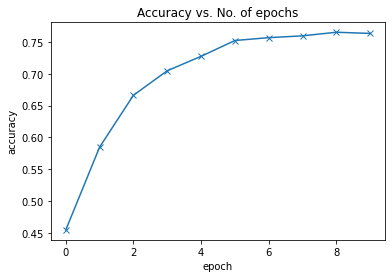

In [34]:
plot_accuracies(history)

In [35]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

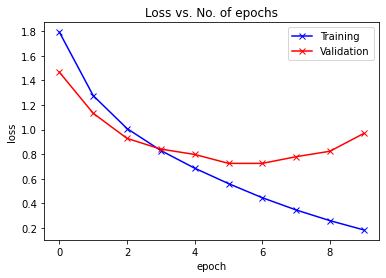

In [36]:
plot_losses(history)

In [37]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


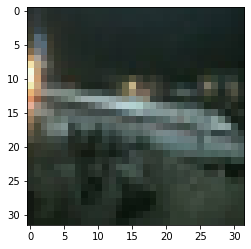

In [38]:
img, label = testset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


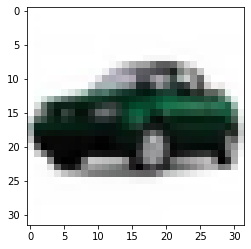

In [39]:
img, label = testset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [40]:
evaluate(model, val_loader)

{'val_loss': 0.9691651463508606, 'val_acc': 0.7635742425918579}

In [41]:
evaluate(model, train_loader)

{'val_loss': 0.11917375028133392, 'val_acc': 0.9601387977600098}